In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing  
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.ticker import MultipleLocator 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [101]:
def draw_week_id(id,start_date='wk_0',end_date='wk_68',figsieze=(16,9)):
    shop_info.loc[id,start_date:end_date].T.plot(figsize=(16,9))
def draw_week_ids(ids,start_date='wk_0',end_date='wk_68',figsieze=(16,9)):
    shop_info.loc[ids,start_date:end_date].T.plot(figsize=(16,9))
def draw_ids(ids,dataset=shop_info,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
        dataset.loc[ids,start_date:end_date].T.plot(figsize=figsize,ax=ax)
    else: dataset.loc[ids,start_date:end_date].T.plot(figsize=figsize)
    plt.show()
def draw_ids_avg(ids,start_date='2015-07-01',end_date='2016-10-31',by_week=True,figsize=(70,10)):
    if by_week:
        xmajorLocator   = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[ids,start_date:end_date].mean(axis=0).plot(figsize=figsize)
    plt.show()
def draw_ids_diff(ids,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):  
    if by_week:
        xmajorLocator   = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    (shop_info.loc[ids[0],start_date:end_date]-shop_info.loc[ids[1],start_date:end_date]).plot(figsize=figsize)
def draw_id(id,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[id,start_date:end_date].plot(legend=True,figsize=figsize)



# Data Cleaning

# train

In [2]:
path = os.getcwd().split('TianChi_IJCAI-17_footfall_prediction_code')[0]

#shop_info = pd.read_table(path+'dataset/shop_info.txt',names=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name'],header=None,delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info = pd.read_table(path+'dataset/shop info with count.csv',delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info.index = shop_info['shop_id'].tolist()

In [3]:
shop_info_num = shop_info.iloc[:,:10].copy()

In [4]:
weekA = shop_info.loc[:,'2016-09-20':'2016-09-26'].copy()
weekB = shop_info.loc[:,'2016-10-11':'2016-10-17'].copy()
weekC = shop_info.loc[:,'2016-10-18':'2016-10-24'].copy()
weekD = shop_info.loc[:,'2016-10-25':'2016-10-31'].copy()

In [5]:
'''  poly   degree=2     '''
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
train_x = weekA.join(weekB)                                    #train = weekA+ weekB + weekC
train_x = train_x.join(weekC)

In [7]:

def every_shop_open_ratio(start_day,end_day):
    Row = len(shop_info.index.tolist())
    row = 0
    Open_ratios = []
    while(row<Row):
        single_row = shop_info.iloc[row]
        single_row = single_row[start_day:end_day]
        open_ratio_ = (single_row>0).sum()/float((pd.to_datetime(end_day).date()-pd.to_datetime(start_day).date()).days+1)
        Open_ratios.append(round(open_ratio_,4))
        row = row+1
    Open_ratios = np.array(Open_ratios)
 
  
    mask = Open_ratios>=0
    df = DataFrame({'shop_id':(shop_info.shop_id)[mask].values,'open_ratio':Open_ratios[mask]},index=np.arange(1,2001))
    return  df   #返回大于threshold的shop_id,以及他们对应的开张比例


In [8]:
train_sum = train_x.sum(axis=1)
train_mean = train_x.mean(axis=1)
train_open_ratio_A = every_shop_open_ratio(start_day='2016-09-20',end_day='2016-09-26')
train_open_ratio_BC = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-24')
train_open_ratio = (train_open_ratio_A.open_ratio + train_open_ratio_BC.open_ratio*2)/3
train_weekend = ['2016-09-24','2016-09-25','2016-10-15','2016-10-16','2016-10-22','2016-10-23']
train_ratio_wk = (train_x[train_weekend]).sum(axis=1)/(train_sum.replace(0,1))
train_std = train_x.std(axis=1)
train_max = train_x.max(axis=1)
train_min = train_x.min(axis=1)
train_median = train_x.median(axis=1)
train_mad = train_x.mad(axis=1)
train_var = train_x.var(axis=1) 

In [9]:
'''将多维数组转换为DataFrame'''
def transfrom_Arr_DF(arr,col_name = 'col_'):
    if(len(arr.shape)==1):
        df = DataFrame(arr,columns=['col_0'])
    else:
        df = DataFrame(arr,columns=[col_name+str(i) for i in range(arr.shape[1])],index=np.arange(1,len(arr)+1))
    return df

'''将一维数组转换为OHE码'''
def make_OHE(names):
    data = []
    for name in names:
        data.append([name])          
    enc = preprocessing.OneHotEncoder()
    enc.fit(data)
    OHE_data = enc.transform(data).toarray()  
    return OHE_data


In [10]:
shop_info_num['score'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['comment_cnt'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['cate_3_name'].replace(np.NaN,u'NaN',inplace=True)

In [11]:
city_name_usual=[u'上海',u'杭州',u'北京',u'广州',u'南京',u'武汉',u'深圳']
shop_info_num.loc[~shop_info_num['city_name'].isin(city_name_usual),'city_name'] = u'其他城市'
cate_1_name_usual=[u'美食',u'超市便利店']
shop_info_num.loc[~shop_info_num['cate_1_name'].isin(cate_1_name_usual),'cate_1_name'] = u'其他'
cate_2_name_usual=[u'快餐',u'超市',u'便利店',u'休闲茶饮',u'小吃',u'休闲食品',u'烘焙糕点',u'中餐',u'其他美食',u'火锅']
shop_info_num.loc[~shop_info_num['cate_2_name'].isin(cate_2_name_usual),'cate_2_name'] = u'其他'
cate_3_name_usual=[u'西式快餐',u'中式快餐',u'生鲜水果',u'奶茶',u'其它小吃',u'面包',u'饮品/甜点',u'面点',u'蛋糕']
shop_info_num.loc[~shop_info_num['cate_3_name'].isin(cate_3_name_usual),'cate_3_name'] = u'其他'


In [12]:
train_x = transfrom_Arr_DF(poly.fit_transform(train_x))

In [13]:

train_x['sumABCD'] = train_sum
train_x['open_ratio'] = train_open_ratio
train_x['ratio_wk'] = train_ratio_wk
train_x['meanABCD'] = train_mean
train_x['std'] = train_std
train_x['max'] = train_max
train_x['min'] = train_min
train_x['median'] = train_median
train_x['mad'] = train_mad
train_x['var'] = train_var

In [14]:
train_x = train_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [15]:
train_x = train_x.join(shop_info_num['location_id'])
train_x = train_x.join(shop_info_num['comment_cnt'])

In [212]:
shop_info_num

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
1,1,其他城市,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
2,2,其他城市,64,19,-1.0,-1.0,1,超市便利店,超市,其他
3,3,其他城市,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
4,4,其他城市,380,18,-1.0,-1.0,1,超市便利店,超市,其他
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果
6,6,其他城市,1139,13,3.0,1.0,0,美食,烘焙糕点,面包
7,7,其他城市,145,13,3.0,9.0,2,美食,快餐,西式快餐
8,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果
9,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,其他
10,10,其他城市,98,10,-1.0,-1.0,0,超市便利店,超市,其他


In [16]:
#加入userview
user_view = pd.read_csv(path+'dataset/shop view separately.csv',index_col=0)

,view_2016-09-20,view_2016-09-21,view_2016-09-22,view_2016-09-23,view_2016-09-24,view_2016-09-25,view_2016-09-26
1,31,20,22,31,25,18,25
2,26,30,30,28,40,40,29
3,6,0,4,2,3,8,2
4,30,22,25,20,57,37,29
5,6,9,4,1,3,5,3
6,6,2,4,6,4,5,12
7,16,23,12,11,14,16,11
8,10,10,7,4,7,10,15
9,7,10,9,8,10,13,11
10,0,1,1,0,1,1,0


In [18]:
view_weekA = user_view.loc[:,'view_2016-09-20':'view_2016-09-26'].copy()
view_weekB = user_view.loc[:,'view_2016-10-11':'view_2016-10-17'].copy()
view_weekC = user_view.loc[:,'view_2016-10-18':'view_2016-10-24'].copy()
view_weekD = user_view.loc[:,'view_2016-10-25':'view_2016-10-31'].copy()

In [20]:
train_x = train_x.join(view_weekA)
train_x = train_x.join(view_weekB)
train_x = train_x.join(view_weekC)

In [21]:
#加入stable_day_

In [22]:
stable_wave_model = pd.read_csv('stable_wave_model.csv',index_col=0)

In [23]:
train_x = train_x.join(stable_wave_model)

In [ ]:
#加入3周余弦相似度 与 近似商家wave

wk1=['2016-09-20','2016-09-26']
wk2=['2016-10-11','2016-10-17']
wk3=['2016-10-18','2016-10-24']

def cal_cos_sim_between(x,wka,wkb):
    wka_vec =  np.array(x[wka[0]:wka[1]].tolist())
    wkb_vec =  np.array(x[wkb[0]:wkb[1]].tolist())
    sim = wka_vec.dot(wkb_vec) / (np.sqrt(np.sum(np.square(wka_vec))) * np.sqrt(np.sum(np.square(wkb_vec))))
    return sim
train_x['cos_sim_between_wk_1_2'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk2),axis=1)
train_x['cos_sim_between_wk_2_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk2,wk3),axis=1)
train_x['cos_sim_between_wk_1_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk3),axis=1)

train_x['cos_sim_between_wk_1_2'].replace(np.NaN,0.0,inplace=True)
train_x['cos_sim_between_wk_2_3'].replace(np.NaN,0.0,inplace=True)
train_x['cos_sim_between_wk_1_3'].replace(np.NaN,0.0,inplace=True)

In [ ]:
#加入天气

In [58]:
weather = pd.read_csv('shop_weather.csv',index_col=0)

In [72]:
weather

,weather_2016-09-20,weather_2016-09-21,weather_2016-09-22,weather_2016-09-23,weather_2016-09-24,weather_2016-09-25,weather_2016-09-26,weather_2016-10-11,weather_2016-10-12,weather_2016-10-13,...,weather_2016-11-05,weather_2016-11-06,weather_2016-11-07,weather_2016-11-08,weather_2016-11-09,weather_2016-11-10,weather_2016-11-11,weather_2016-11-12,weather_2016-11-13,weather_2016-11-14
1,1,1,1,1,1,1,1,1,0,1,...,1,1,0,0,1,1,1,1,1,1
2,1,1,1,1,0,1,0,1,1,1,...,0,0,0,1,1,0,0,1,0,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,1,0,1
4,1,1,1,1,1,1,0,1,1,1,...,0,1,1,1,1,1,1,1,0,1
5,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,1,0,0,0
6,1,1,1,0,1,1,1,1,1,1,...,1,1,0,1,1,0,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,1,0,1,0
8,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,1,0,0,0
9,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,1,0,0,0
10,1,1,1,1,1,0,1,1,1,0,...,1,1,0,1,0,1,1,1,1,1


In [73]:
train_x = train_x.join(weather.loc[:,'weather_2016-09-20':'weather_2016-10-31'])

In [71]:
train_x

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,wave_model2_2,wave_model2_3,wave_model2_4,wave_model2_5,wave_model2_6,wave_model2_7,ids_stable_period_1,ids_stable_period_2,ids_stable_period_3,ids_no_stable_period
1,223.0,206.0,220.0,241.0,272.0,240.0,225.0,254.0,239.0,228.0,...,233.500000,245.916667,257.750000,250.833333,234.416667,233.833333,1,0,0,0
2,77.0,82.0,71.0,71.0,96.0,121.0,67.0,0.0,0.0,0.0,...,96.250000,83.375000,90.125000,117.500000,123.000000,91.750000,1,0,0,0
3,62.0,59.0,55.0,79.0,112.0,83.0,88.0,68.0,63.0,56.0,...,71.142857,66.285714,73.428571,81.142857,84.571429,69.000000,0,1,0,0
4,74.0,101.0,102.0,98.0,203.0,199.0,91.0,86.0,113.0,71.0,...,115.428571,102.857143,114.857143,201.714286,220.142857,110.142857,0,1,0,0
5,277.0,272.0,309.0,182.0,179.0,4.0,305.0,223.0,218.0,230.0,...,269.000000,260.285714,217.142857,215.428571,197.142857,309.000000,0,0,1,0
6,77.0,68.0,74.0,73.0,67.0,89.0,83.0,83.0,91.0,90.0,...,46.600000,49.000000,62.400000,57.800000,58.600000,59.000000,0,1,0,0
7,105.0,116.0,105.0,141.0,168.0,180.0,109.0,136.0,93.0,128.0,...,152.200000,170.200000,184.800000,166.000000,212.000000,162.000000,1,0,0,0
8,62.0,65.0,57.0,71.0,69.0,73.0,55.0,81.0,63.0,65.0,...,106.500000,88.000000,95.250000,92.750000,86.000000,75.250000,0,1,0,0
9,238.0,214.0,229.0,242.0,288.0,324.0,212.0,225.0,202.0,192.0,...,205.520000,197.320000,203.760000,230.080000,238.040000,200.160000,1,0,0,0
10,73.0,104.0,69.0,76.0,73.0,89.0,80.0,108.0,111.0,73.0,...,66.000000,50.600000,52.600000,57.400000,72.400000,61.400000,0,0,1,0


#### train_y

In [25]:
train_y = weekD

### 检查 train_x train_y 是否符合要求 不包含NaN

In [26]:
 def fresh_ids():
    ids = range(1,2001)
    np.random.shuffle(ids)
    #print ids
    train_set_ids = ids[:1600]
    val_set_ids = ids[1600:]
    return train_set_ids,val_set_ids

In [ ]:
feature_list = [i for i in train_x.columns.tolist() if i not in ['col_'+str(num) for num in range(21,231)]]


In [74]:
train_set_ids,val_set_ids = fresh_ids()
train_set_ids =range(1,1601)
val_set_ids = range(1601,2001)
RF = RandomForestRegressor(n_estimators=1600,
                            random_state=1,
                            n_jobs=-1,
                            min_samples_split=2,
                            min_samples_leaf=2,)
#print RF.score(train_x,train_y)
RF.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])
print RF.score(train_x,train_y)
predict_val = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score

0.935008458316
0.0876963924706


 train_score add location_id & comment_cnt
0.0770314034279
0.0779705913349
0.078948579937
0.0797655132658
0.0827867281122
0.0830453170442
0.0875721485457  -- 0.954111600465
0.0833575682115 
0.081675846769
0.0830629914982 
 加入 userview
0.0751307632343
0.0764668232205
0.0781205661011
 1600,400
0.0878128199044
 加入 三周余弦相似度（drop)
0.0878918600216
 加入 天气
0.0876963924706

In [75]:
train_set_ids,val_set_ids = fresh_ids()
train_set_ids =range(1,1601)
val_set_ids = range(1601,2001)
ET = ExtraTreesRegressor(n_estimators=1600,
                           random_state=1,
                           n_jobs=-1,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_depth=25,
                           max_features='auto')
ET.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])

predict_val = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score


0.0865599468872


#### train_score add location_id & comment_cnt

0.081000335966
0.0798722568859
0.0775547455471 

#### 加入 stable wave model max_features=290
0.0799956351718
0.0856649743061
0.0814708388275
0.0834221709742
#### 加入 userview
0.0800946904414
0.0820529531944
0.0817082217219
#### 1600,400
0.0867150894683
#### 加入 三周余弦相似度
0.0867362577526
####  max_features='auto'
0.0866585563586
####  天气
0.0865599468872

## 看看训练时的error都出在什么id上，是否要制定规则

In [113]:
ids_high_error = []
for id in range(2000):
    train_score = 0.0
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id,day] - predict_train.iloc[id,day]))/(train_y.iloc[id,day] + predict_train.iloc[id,day])/(7)
    #print id+1,train_score
    if train_score > 0.2:
        ids_high_error.append(id+1)
        

In [114]:
ids_high_error

[5,
 23,
 352,
 444,
 459,
 470,
 524,
 561,
 632,
 659,
 810,
 1058,
 1163,
 1185,
 1218,
 1243,
 1384,
 1407,
 1418,
 1526,
 1556,
 1650,
 1707,
 1716,
 1824,
 1856,
 1858,
 1918]

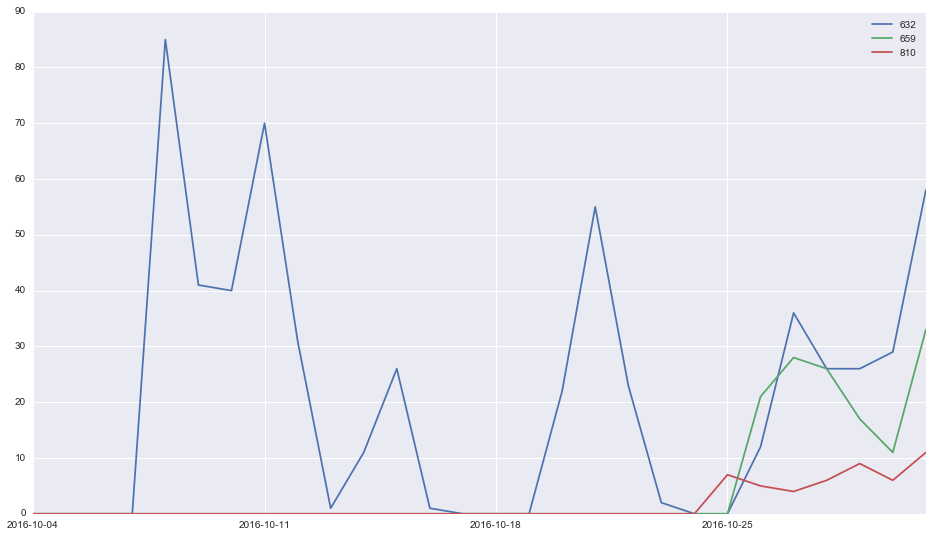

In [124]:
draw_ids(ids_high_error[8:11],dataset=shop_info,start_date = '2016-10-04',by_week=True)

In [99]:
train_predict_find_error = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

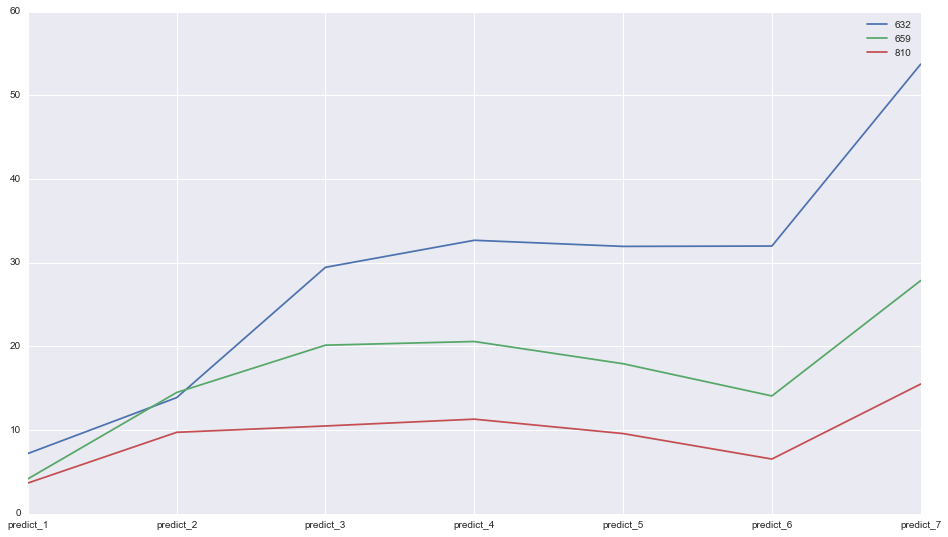

In [122]:
draw_ids(ids_high_error[8:11],dataset=train_predict_find_error ,start_date = 'predict_1',end_date='predict_7')

### 开始训练

In [76]:
RF = RandomForestRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=None)
RF.fit(train_x,train_y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1600, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [77]:
ET = ExtraTreesRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=25,max_features=None)
ET.fit(train_x,train_y)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=25,
          max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=2, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=-1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [78]:
RF.score(train_x,train_y)

0.96604498211593814

0.96566366376351054 max_depth = 25 / none n_estimators=1200
0.96595 n_estimators=1600
0.96602585097285765  加入 stable wave model
 加入 userview
0.96589687506866584
  加入 三周余弦相似度 （dropped)
0.96601672768808777 
 天气
0.96604498211593814

In [79]:
ET.score(train_x,train_y)

0.98425916547308967

0.98402907280130347 no max_features
0.98404200338521919 max_features=270
0.98403486778744087  加入 stable wave model
0.98406360722194519 max_features=280
0.98408096361968167  max_features=290
 加入 userview
0.98408958618737985
 加入 三周余弦相似度 (dropped)
0.98407059228426352
max_features=300
0.98413913215600435
max_features=none
0.98419761469576117
 天气
0.98425916547308967

### 查看比赛定义的训练成绩（仅1周的）

In [128]:
train_y

,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
1,255,172,226,257,251,281,180
2,82,97,83,96,96,115,80
3,80,61,68,103,102,104,67
4,90,104,55,110,215,196,115
5,302,1,0,215,203,291,239
6,97,100,117,133,109,118,86
7,128,115,111,128,165,162,81
8,70,68,72,49,70,71,35
9,210,197,245,205,291,283,212
10,77,114,85,84,99,93,121


In [85]:
predict_train = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_train.loc[:,'predict_'+str(i)] = predict_train.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

In [82]:
predict_train = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_train.loc[:,'predict_'+str(i)] = predict_train.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

In [86]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id,day] - predict_train.iloc[id,day]))/(train_y.iloc[id,day] + predict_train.iloc[id,day])/(7*2000)
        
        

In [87]:
train_score

0.046010419541393226

In [ ]:
0.046128191132625
0.04603659731204112 (rf)
0.029443343537153256 (et)
0.046010419541393226 (rf) add weather
0.02912634783553982 (et)

### feature importance

In [125]:
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('RF_feature_importance_.csv', sep=",", index = False)
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(ET.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('ET_feature_importance_.csv', sep=",", index = False)

# offline test :  

In [184]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(weekD.iloc[id,day] - result.iloc[id,day]))/(weekD.iloc[id,day] + result.iloc[id,day])/(7*2000)
        
print train_score

IndexError: single positional indexer is out-of-bounds

# test

In [35]:
test_x = weekB.join(weekC)                                         #test = weekB + weekC + weekD 
test_x = test_x.join(weekD)


test_sum = test_x.sum(axis=1)
test_mean = test_x.mean(axis=1)
test_open_ratio = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-31')
test_weekend = ['2016-10-15','2016-10-16','2016-10-22','2016-10-23','2016-10-29','2016-10-30']
test_ratio_wk = (test_x[test_weekend]).sum(axis=1)/(test_sum.replace(0,1))
test_std = test_x.std(axis=1)
test_max = test_x.max(axis=1)
test_min = test_x.min(axis=1)
test_median = test_x.median(axis=1)
test_mad = test_x.mad(axis=1)
test_var = test_x.var(axis=1)



In [36]:
test_x = transfrom_Arr_DF(poly.fit_transform(test_x))

test_x['sumABCD'] = test_sum
test_x['open_ratio'] = test_open_ratio.open_ratio
test_x['ratio_wk'] = test_ratio_wk
test_x['meanABCD'] = test_mean
test_x['std'] = test_std
test_x['max'] = test_max
test_x['min'] = test_min
test_x['median'] = test_median
test_x['mad'] = test_mad
test_x['var'] = test_var

In [37]:
test_x = test_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [38]:
test_x = test_x.join(shop_info_num['location_id'])
test_x = test_x.join(shop_info_num['comment_cnt'])

In [39]:


test_x = test_x.join(view_weekB)
test_x = test_x.join(view_weekC)
test_x = test_x.join(view_weekD)


In [40]:
test_x = test_x.join(stable_wave_model)

In [80]:
test_x = test_x.join(weather.loc[:,'weather_2016-10-11':'weather_2016-11-07'])

In [ ]:
"""
wk1=['2016-10-11','2016-10-17']
wk2=['2016-10-18','2016-10-24']
wk3=['2016-10-25','2016-10-31']
def cal_cos_sim_between(x,wka,wkb):
    wka_vec =  np.array(x[wka[0]:wka[1]].tolist())
    wkb_vec =  np.array(x[wkb[0]:wkb[1]].tolist())
    sim = wka_vec.dot(wkb_vec) / (np.sqrt(np.sum(np.square(wka_vec))) * np.sqrt(np.sum(np.square(wkb_vec))))
    return sim
test_x['cos_sim_between_wk_1_2'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk2),axis=1)
test_x['cos_sim_between_wk_2_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk2,wk3),axis=1)
test_x['cos_sim_between_wk_1_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk3),axis=1)

test_x['cos_sim_between_wk_1_2'].replace(np.NaN,0.0,inplace=True)
test_x['cos_sim_between_wk_2_3'].replace(np.NaN,0.0,inplace=True)
test_x['cos_sim_between_wk_1_3'].replace(np.NaN,0.0,inplace=True)
"""

## 检查是否columns是否相同

In [90]:
for i in range(len(train_x.columns.tolist())):
    if train_x.columns.tolist()[i] != test_x.columns.tolist()[i]:
        print train_x.columns.tolist()[i],test_x.columns.tolist()[i]

view_2016-09-20 view_2016-10-11
view_2016-09-21 view_2016-10-12
view_2016-09-22 view_2016-10-13
view_2016-09-23 view_2016-10-14
view_2016-09-24 view_2016-10-15
view_2016-09-25 view_2016-10-16
view_2016-09-26 view_2016-10-17
view_2016-10-11 view_2016-10-18
view_2016-10-12 view_2016-10-19
view_2016-10-13 view_2016-10-20
view_2016-10-14 view_2016-10-21
view_2016-10-15 view_2016-10-22
view_2016-10-16 view_2016-10-23
view_2016-10-17 view_2016-10-24
view_2016-10-18 view_2016-10-25
view_2016-10-19 view_2016-10-26
view_2016-10-20 view_2016-10-27
view_2016-10-21 view_2016-10-28
view_2016-10-22 view_2016-10-29
view_2016-10-23 view_2016-10-30
view_2016-10-24 view_2016-10-31
weather_2016-09-20 weather_2016-10-11
weather_2016-09-21 weather_2016-10-12
weather_2016-09-22 weather_2016-10-13
weather_2016-09-23 weather_2016-10-14
weather_2016-09-24 weather_2016-10-15
weather_2016-09-25 weather_2016-10-16
weather_2016-09-26 weather_2016-10-17
weather_2016-10-11 weather_2016-10-18
weather_2016-10-12 weath

In [42]:
result = ET.predict(test_x)
pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]).to_csv('regression_prediction.csv', sep=",", index = True)

In [43]:
result = pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

## 预测第二周 相比于第一周更换了天气特征～

In [129]:
test_x_2 = test_x.copy()

In [134]:
for i in ['weather_'+ date for date in dateRange('2016-10-11','2016-11-07')]:
    del test_x_2[i]

In [136]:
test_x_2 = test_x_2.join(weather.loc[:,'weather_2016-10-18':'weather_2016-10-31'])
test_x_2 = test_x_2.join(weather.loc[:,'weather_2016-11-08':'weather_2016-11-14'])

In [44]:
result2 = ET.predict(test_x_2)
result2 = pd.DataFrame(result2,index=range(1,2001),columns=['predict_'+str(i) for i in range(8,15)])


In [86]:
result2

,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14
1,212.498538,206.908740,222.784119,239.042572,252.837417,251.737746,202.960860
2,62.588502,59.901520,67.110428,85.449865,131.354976,128.968339,66.657881
3,70.060190,68.765203,74.306940,88.028486,115.673109,115.159782,71.190571
4,89.965326,83.482185,87.636577,116.346022,189.571891,192.262767,97.815757
5,187.401339,163.645737,180.574942,196.458319,219.894566,231.257391,182.217463
6,106.974638,107.857020,110.392913,120.139445,113.891967,113.406336,107.703108
7,114.938275,108.075326,124.412542,135.635949,170.148819,172.783225,114.523891
8,52.171075,54.670674,60.397617,62.330464,75.820278,72.189183,52.579308
9,211.460984,207.092887,225.640975,237.214041,254.837854,256.034592,200.259442
10,97.286709,93.040390,97.527611,99.083124,101.672757,102.748990,101.036256


## 结果可视化

In [45]:
def dateRange(start, end):
    days = (datetime.datetime.strptime(end, "%Y-%m-%d") - datetime.datetime.strptime(start, "%Y-%m-%d")).days + 1
    return [datetime.datetime.strftime(datetime.datetime.strptime(start, "%Y-%m-%d") + datetime.timedelta(i), "%Y-%m-%d") for i in xrange(days)]


In [46]:
shop_info = shop_info.join(pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]))

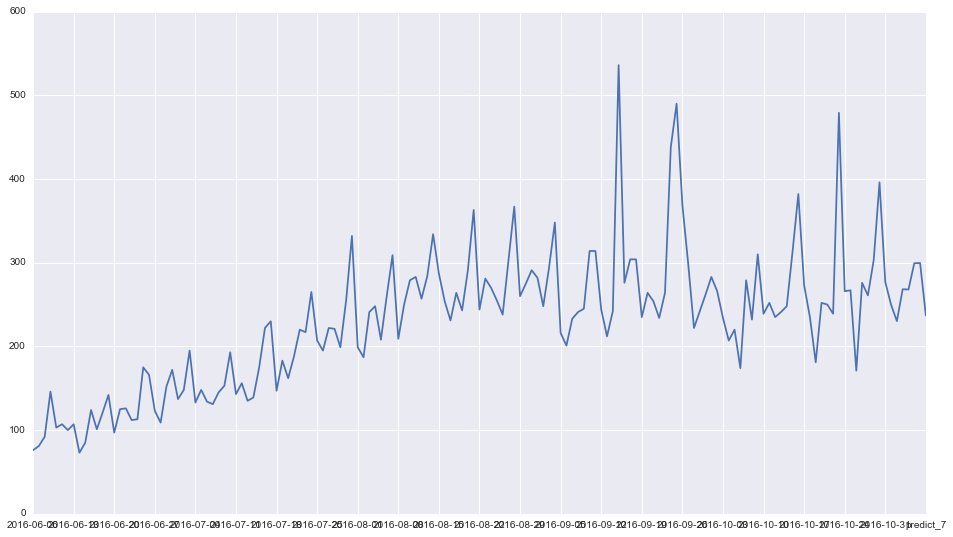

In [47]:

list_result = dateRange('2016-06-06','2016-10-31')
for i in range(1,8):
    list_result.append('predict_'+str(i))

xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
ax = plt.subplot(111) 
ax.xaxis.set_major_locator(xmajorLocator)
shop_info.loc[180,list_result].T.plot(figsize=(16,9),ax=ax)

In [48]:

#  占个格子 &&  cal avg sales count each day
total_day = pd.to_datetime('2016-11-01').date()-pd.to_datetime('2015-07-01').date() 
total_day = total_day.days
total_week = total_day / 7  # 69个
start_day = pd.to_datetime('2016-11-01').date() - datetime.timedelta(total_week*7)
#print start_day
for week_number in range(total_week): # 0~68
    start_day_of_week = start_day +  datetime.timedelta(week_number*7) 
    end_day_of_week = start_day_of_week + datetime.timedelta(6)
    start_day_of_week =   start_day_of_week.strftime("%Y-%m-%d")
    end_day_of_week = end_day_of_week.strftime("%Y-%m-%d")
    print start_day_of_week,end_day_of_week
    shop_info['wk_'+str(week_number)] = shop_info.loc[:,start_day_of_week:end_day_of_week].mean(axis=1)

2015-07-07 2015-07-13
2015-07-14 2015-07-20
2015-07-21 2015-07-27
2015-07-28 2015-08-03
2015-08-04 2015-08-10
2015-08-11 2015-08-17
2015-08-18 2015-08-24
2015-08-25 2015-08-31
2015-09-01 2015-09-07
2015-09-08 2015-09-14
2015-09-15 2015-09-21
2015-09-22 2015-09-28
2015-09-29 2015-10-05
2015-10-06 2015-10-12
2015-10-13 2015-10-19
2015-10-20 2015-10-26
2015-10-27 2015-11-02
2015-11-03 2015-11-09
2015-11-10 2015-11-16
2015-11-17 2015-11-23
2015-11-24 2015-11-30
2015-12-01 2015-12-07
2015-12-08 2015-12-14
2015-12-15 2015-12-21
2015-12-22 2015-12-28
2015-12-29 2016-01-04
2016-01-05 2016-01-11
2016-01-12 2016-01-18
2016-01-19 2016-01-25
2016-01-26 2016-02-01
2016-02-02 2016-02-08
2016-02-09 2016-02-15
2016-02-16 2016-02-22
2016-02-23 2016-02-29
2016-03-01 2016-03-07
2016-03-08 2016-03-14
2016-03-15 2016-03-21
2016-03-22 2016-03-28
2016-03-29 2016-04-04
2016-04-05 2016-04-11
2016-04-12 2016-04-18
2016-04-19 2016-04-25
2016-04-26 2016-05-02
2016-05-03 2016-05-09
2016-05-10 2016-05-16
2016-05-17

In [49]:
shop_info['result_avg'] = shop_info.loc[: ,['predict_'+str(i) for i in range(1,8)]].mean(axis=1)

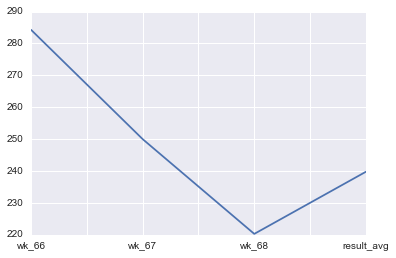

In [50]:
shop_info.loc[39,'wk_66':'result_avg'].plot()

In [ ]:
## 保存结果

In [51]:
result_total = result.join(result2)

In [52]:
for i in range(1,15):
    result_total.loc[:,'predict_'+str(i)] = result_total.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))
    

In [53]:
result_total.to_csv('regression_prediction_two_week(2 et).csv', sep=",", index = True)